### Seed

In [1]:
import matplotlib.pyplot as plt
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv

In [2]:
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.set_random_seed(seed_value)

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Read Dataset

In [3]:
def getOneHot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

In [4]:
def getData(path, folders):
    path+='/'
    labelNames = folders
    labels = []
    images = []
    temp = []
    for i in range(len(folders)):
        randomImages = []
        imgAddress = path + folders[i]
        l = os.listdir(imgAddress)
        for img in l:
            frame = cv.imread(imgAddress+'/'+img)
            temp.append((i,frame))
    random.shuffle(temp)
    for x in temp:
        temp1, temp2 = (x)
        labels.append(temp1)
        images.append(temp2)
    labels = getOneHot(np.asarray(labels))
    images = np.asarray(images)
    return images, labels

In [5]:
def preprocess(a):
    b = []
    for action_frame in a:
        hsv = cv.cvtColor(action_frame, cv.COLOR_BGR2HSV)
        lower_color = np.array([0, 10, 60])
        upper_color = np.array([20, 150, 255])
        mask = cv.inRange(hsv, lower_color, upper_color) 
        res = cv.bitwise_and(action_frame,action_frame, mask= mask)
        b.append(res)
    return b

In [6]:
labelNames = ['next', 'previous', 'stop']
x_train, y_train = getData('completeData', labelNames)

In [7]:
x_train = np.asarray(preprocess(x_train))

### Show images

In [8]:
def showImg(images, labels, labelNames):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        n = random.randint(0,len(images))
        plt.imshow(images[n])
        plt.xlabel(labelNames[np.argmax(labels[n])])
    plt.show()

Training data:


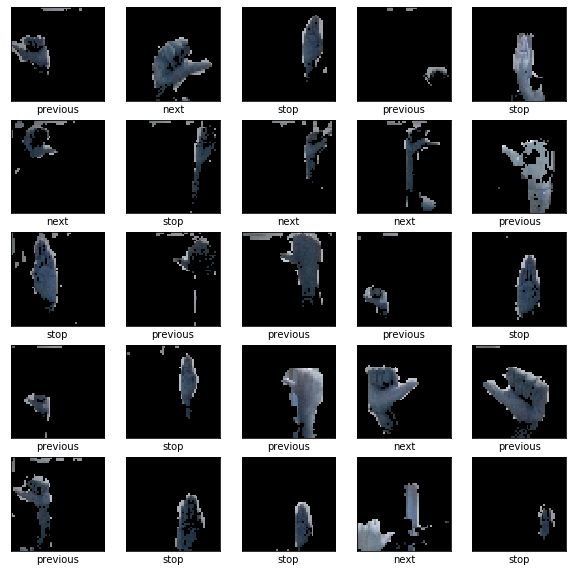

In [9]:
print("Training data:")
showImg(x_train, y_train, labelNames)

### CNN architecture

In [10]:
def get_model(layer1Filter = 16, layer2Filter = 32, layer3Filter = 64, layer4Output = 400, optim = 'adam'):
    x = Input((50, 50, 3))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = layer1Filter, kernel_size = (3,3), activation='relu')(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.5, seed = seed_value)(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = layer2Filter, kernel_size = (3,3), activation='relu')(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.5, seed = seed_value)(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = layer3Filter, kernel_size = (3,3), activation='relu')(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.5, seed = seed_value)(model)
    
    model = Flatten()(model)
    model = Dense(layer4Output , activation = 'relu')(model)
    model = Dropout(0.5, seed = seed_value)(model)
    model = Dense(3, activation = 'softmax')(model)
    
    model = Model(input = x, output = model)
    
    if optim == 'adam':
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    else:
        opt = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
        
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.75, patience=patience_lr, verbose=1, epsilon=1e-4)
    return [mcp_save, reduce_lr_loss]


In [12]:
def train_model(x_train, y_train, layer4Output, optim, epochs):
    name_weights = "final_model_weights_complete.h5"
    model = get_model(layer4Output = layer4Output, optim = optim)
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=2)
    model.fit(x = x_train, y = y_train, epochs = epochs, callbacks=callbacks)
    return model

In [13]:
model = train_model(x_train, y_train, 400, 'adam', 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
6188/6188 [==============================] - 23s 4ms/step - loss: 0.7075 - accuracy: 0.6440
Epoch 2/20
6188/6188 [==============================] - 22s 4ms/step - loss: 0.5588 - accuracy: 0.7178
Epoch 3/20
6188/6188 [==============================] - 20s 3ms/step - loss: 0.3781 - accuracy: 0.8302
Epoch 4/20
6188/6188 [==============================] - 17s 3ms/step - loss: 0.2708 - accuracy: 0.8846
Epoch 5/20
6188/6188 [==============================] - 17s 3ms/step - loss: 0.2301 - accuracy: 0.9080
Epoch 6/20
6188/6188 [==============================] - 17s 3ms/step - loss: 0.1909 - accuracy: 0.9223
Epoch 7/20
6188/6188 [==============================] - 18s 3ms/step - loss: 0.1744 - accuracy: 0.9271
Epoch 8/20
6188/6188 [==============================] - 19s 3ms/step - loss: 0.1671 - accuracy: 0.9323
Epoch 9/20
6188/6188 [==============================] - 18s 3ms/step - loss: 0.14

KeyboardInterrupt: 

### Prediction

In [ ]:
cap = cv.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Unable to capture video")
        break
    frame = cv.flip( frame, 1 )
    frame2 = cv.resize(frame, (50, 50))
    a = []
    a.append(frame2)
    a = np.array(preprocess(a))
    prob = model.predict(a)
    pred = np.argmax(prob)
    if prob[0][pred] < 0.9:
        s = "Background " + str(prob[0])
    else:
        s = labelNames[pred] + " " + str(prob[0][pred])
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(frame,s,(40,40),font,0.70,(0,0,255),2)
    cv.imshow('frame', frame)
    cv.imshow('frame2', a[0])
    if cv.waitKey(10) & 0xFF == ord('q'):
        break 

cap.release()
cv.destroyAllWindows()

### Using trained model

In [14]:
def load_trained_model(weights_path):
    model= get_model()
    model.load_weights(weights_path)
    return model

In [15]:
model = load_trained_model("/home/ankit/Desktop/Acad/Sem/Sem5/COL780/Assn/4/weightsComplete.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
